<a href="https://colab.research.google.com/github/sanislearning/ml_playground/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [3]:
drive.mount("/content/drive")
file_path='/content/drive/MyDrive/PData/mnist/train-images.idx3-ubyte'

Mounted at /content/drive


In [4]:
import struct #helps interpret bytes as packed binary data, lets us read IDX file format
with open(file_path,'rb') as f: #rb means read binary
  #Read the magic number and dimensions
  magic,num_images,rows,cols=struct.unpack('>IIII',f.read(16))
  #f.read(16) means that you read first 16 bytes, ie header of IDX file, ie metadata of file
  #struct.unpack('>IIII',...) interprets those 16 bytes as 4 big-endian unsigned integers
  # > =  Big endian (most significant byte first)

  print("Magic Number: ",magic)
  print("Number of Images: ",num_images)
  print("Image Size: ",rows,"x",cols)
  image_bytes=f.read(rows*cols)  #reads only the first image
  image=np.frombuffer(image_bytes,dtype=np.uint8).reshape((rows,cols))
  #converts the bytes into a NumPy array and then reshapes it into a 2D array of shape

Magic Number:  2051
Number of Images:  60000
Image Size:  28 x 28


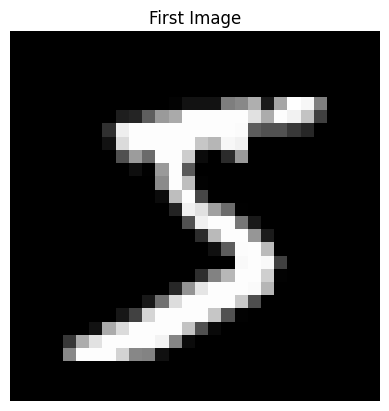

In [5]:
#Visualizing the Image
plt.imshow(image,cmap='gray')
plt.title("First Image")
plt.axis('off')
plt.show()